In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
import pandas as pd

In [2]:
np.random.seed(0)
def get_surgery_time(mean,std):
    sh,sc = (mean/std)**2,std**2/mean
    return np.random.gamma(shape=sh,scale=sc)

In [3]:
#problem parameters
specs = ['CARD','GASTRO','GYN','MED','ORTHO','URO']

surgery_data = {'CARD':[99.0,53.0],'GASTRO':[132.0,76.0],'GYN':[78.0,52.0],'MED':[75.0,32.0],'ORTHO':[142.0,58.0],'URO':[72.0,38.0]}

blocks = {'CARD':[2,6,16,28,32,33],'GASTRO':[1,8,14,15,22,27,34],'GYN':[4,11,12,18,19,24,25,30,35],'MED':[17,36],'ORTHO':[3,9,10,21,23,29,37],'URO':[5,7,13,20,26,31,38]}
block_len = [8*60 for i in range(32)]+[60*60 for i in range(len(specs))]
n_blocks = len(block_len)

n_surgeries = 70
percent_surg = {'CARD':14,'GASTRO':18,'GYN':28,'MED':5,'ORTHO':17,'URO':18}
surgeries = {}
tot = 0
for i in specs[:len(specs)-1]:
    surgeries[i] = round(n_surgeries*percent_surg[i]/100.0)
    tot += surgeries[i]
surgeries[specs[-1]] = n_surgeries-tot

surgery_nums = {}
t = 0
for s in specs:
    surgery_nums[s] = [t,t+surgeries[s]-1]
    t = t+surgeries[s]
    
print(surgeries)
print(surgery_nums)

{'CARD': 10, 'GASTRO': 13, 'GYN': 20, 'MED': 4, 'ORTHO': 12, 'URO': 11}
{'CARD': [0, 9], 'GASTRO': [10, 22], 'GYN': [23, 42], 'MED': [43, 46], 'ORTHO': [47, 58], 'URO': [59, 69]}


In [4]:
np.random.seed(0)
cib = np.array([[0.0 for _ in range(n_blocks)] for _ in range(n_surgeries)]) # block costs
for s in specs:
    for i in range(surgery_nums[s][0],surgery_nums[s][1]):
        costs = sorted([np.random.randint(low=1,high=5)*100 for _ in range(len(blocks[s])-1)])
        #costs = [np.random.randint(low=1,high=5)*110 for _ in range(len(blocks[s])-1)]
        f = 0
        for b in blocks[s][:len(blocks[s])-1]:
            cib[i,b-1] = costs[f]
            f += 1
            
        
dummy_cost = 800
for s in specs:
    for i in range(surgery_nums[s][0],surgery_nums[s][1]):
        b = blocks[s][-1]
        cib[i,b-1] = dummy_cost

cob = np.array([5.0 for _ in range(n_blocks)])
cgb = np.array([5.0/1.5 for _ in range(n_blocks-len(specs))]+[0.0 for _ in range(len(specs))])

In [5]:
#block and surgery of a speciality fesibility
p = [[0 for _ in range(n_blocks)] for _ in range(n_surgeries)]
p = np.array(p)
t = 0
for s in specs:
    for i in range(surgeries[s]):
        for b in blocks[s]:
            p[t,b-1] = 1
        t += 1

In [6]:
n_scenarios = 10**3
avg_model = ConcreteModel()
avg_model.y = Var(RangeSet(n_surgeries),RangeSet(n_blocks),domain=Binary)
avg_model.o = Var(RangeSet(n_blocks),RangeSet(n_scenarios),domain=NonNegativeReals)
avg_model.g = Var(RangeSet(n_blocks),RangeSet(n_scenarios),domain=NonNegativeReals)

avg_model.atmost1 = ConstraintList()
for i in range(n_surgeries):
    avg_model.atmost1.add(expr=sum(avg_model.y[i+1,b] for b in range(1,n_blocks+1))==1)

avg_model.specfeas = ConstraintList()
for i in range(n_surgeries):
    for b in range(n_blocks):
        avg_model.specfeas.add(expr=avg_model.y[i+1,b+1] <= p[i,b])

avg_model.ogcons = ConstraintList()
for n in range(n_scenarios):
    t = 0
    for s in specs:
        for b in blocks[s]:
            avg_model.ogcons.add(expr=avg_model.o[b,n+1]-avg_model.g[b,n+1] == sum(get_surgery_time(surgery_data[s][0],surgery_data[s][1])*avg_model.y[i+1,b] for i in range(surgery_nums[s][0],surgery_nums[s][1]+1))-block_len[b-1])

avg_model.cost = Objective(expr=sum(sum(avg_model.y[i+1,b+1]*cib[i,b] for i in range(n_surgeries)) for b in range(n_blocks))+(sum(cob[b]*avg_model.o[b+1,n+1]+cgb[b]*avg_model.g[b+1,n+1] for b in range(n_blocks) for n in range(n_scenarios)))/n_scenarios,sense=minimize)

In [7]:
opt = SolverFactory('cplex')
opt.options['timelimit'] = 3600
result = opt.solve(avg_model,tee=True)
print("Solver status :",result.solver.status)
print("Solver Termination condition :", result.solver.termination_condition)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\91824\AppData\Local\Temp\tmp9sk9rlgk.cplex.log' open.
CPLEX> New value for time limit in seconds: 3600
CPLEX> Problem 'C:\Users\91824\AppData\Local\Temp\tmpopt2xof7.pyomo.lp' read.
Read time = 0.53 sec. (11.81 ticks)
CPLEX> Problem name         : C:\Users\91824\AppData\Local\Temp\tmpopt2xof7.pyomo.lp
Objective sense      : Minimize
Variables            :   78661  [Nneg: 76001,  Binary: 2660]
Objective nonzeros   :   70462
Linear constraints   :   40731  [Less: 2660,  Equal: 38071]
  Nonzeros           :  581321
  RHS nonzeros       :   38571

Variables            : Min LB: 0.000000   

   3037  2291    37811.4164    60    37864.8376    37519.6904   595365    0.91%
   3159  2308    37638.1404    80    37864.8376    37520.9109   601890    0.91%
   3244  2403    37853.5621    66    37864.8376    37521.5529   621540    0.91%
   3293  2480    37696.2855    80    37864.8376    37521.5529   640558    0.91%
Elapsed time = 276.97 sec. (58033.70 ticks, tree = 467.10 MB, solutions = 14)

Performing restart 1

Repeating presolve.
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 62 columns.
Reduced MIP has 31049 rows, 62396 columns, and 488209 nonzeros.
Reduced MIP has 430 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 18.75 sec. (1832.91 ticks)
Tried aggregator 1 time.
Reduced MIP has 31049 rows, 62396 columns, and 488209 nonzeros.
Reduced MIP has 430 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 24.77 sec. (1914.83 ticks)
Represolve time = 48.81 sec. (3967.85 ticks)
*  3298+    0                        37854.4732    37523.2027      

  26893  6456        cutoff          37825.9196    37785.6232  3559765    0.11%
* 27738  6273      integral     0    37825.3133    37789.6525  3638388    0.09%
  28618  5869        cutoff          37825.3133    37793.3667  3759827    0.08%
  29441  5286    37823.4523    22    37825.3133    37796.8104  3891907    0.08%
  30448  4674        cutoff          37825.3133    37800.6907  4003070    0.07%
  31518  4001        cutoff          37825.3133    37805.1745  4094866    0.05%
  32736  2903        cutoff          37825.3133    37810.0950  4208354    0.04%
  34225  1463        cutoff          37825.3133    37816.3180  4298391    0.02%
  35115   800        cutoff          37825.3133    37819.7186  4320612    0.01%
Elapsed time = 2206.22 sec. (354301.29 ticks, tree = 33.25 MB, solutions = 24)
  35116   809        cutoff          37825.3133    37819.7186  4320414    0.01%
  35117   792        cutoff          37825.3133    37819.7186  4320805    0.01%
  35118   819        cutoff          3782

In [8]:
pd.DataFrame(cib).to_csv("cost_data_random_seed0.csv")

In [9]:
l = [[] for _ in range(n_blocks)]
for b in range(n_blocks):
    for i in range(n_surgeries):
        if avg_model.y[i+1,b+1].value > 0.0:
            l[b].append(i)

for i in range(len(l)):
    print("Block :",i+1, 'Surgeries',l[i])
    

Block : 1 Surgeries [10, 11, 12]
Block : 2 Surgeries [1, 4, 7, 8]
Block : 3 Surgeries [48, 52, 53]
Block : 4 Surgeries [27, 29, 30, 33, 41]
Block : 5 Surgeries [61, 64, 66, 68]
Block : 6 Surgeries [0, 2, 6]
Block : 7 Surgeries [59, 62, 67]
Block : 8 Surgeries [18, 20]
Block : 9 Surgeries [50, 56]
Block : 10 Surgeries [47, 54]
Block : 11 Surgeries [24, 32, 38, 40]
Block : 12 Surgeries [25, 35, 36, 39]
Block : 13 Surgeries [60, 63, 65]
Block : 14 Surgeries [13, 19]
Block : 15 Surgeries [16, 21]
Block : 16 Surgeries [3, 9]
Block : 17 Surgeries [43, 44, 45, 46]
Block : 18 Surgeries [23, 26, 31, 34]
Block : 19 Surgeries [28]
Block : 20 Surgeries []
Block : 21 Surgeries [55, 57]
Block : 22 Surgeries [14, 15]
Block : 23 Surgeries [49, 51]
Block : 24 Surgeries [37, 42]
Block : 25 Surgeries []
Block : 26 Surgeries []
Block : 27 Surgeries [17, 22]
Block : 28 Surgeries []
Block : 29 Surgeries [58]
Block : 30 Surgeries []
Block : 31 Surgeries [69]
Block : 32 Surgeries [5]
Block : 33 Surgeries []
B

In [10]:
surgery_nums

{'CARD': [0, 9],
 'GASTRO': [10, 22],
 'GYN': [23, 42],
 'MED': [43, 46],
 'ORTHO': [47, 58],
 'URO': [59, 69]}

In [11]:
for i in specs:
    print(i, blocks[i])

CARD [2, 6, 16, 28, 32, 33]
GASTRO [1, 8, 14, 15, 22, 27, 34]
GYN [4, 11, 12, 18, 19, 24, 25, 30, 35]
MED [17, 36]
ORTHO [3, 9, 10, 21, 23, 29, 37]
URO [5, 7, 13, 20, 26, 31, 38]


In [12]:
assignments = np.array([[0.0 for _ in range(n_blocks)] for _ in range(n_surgeries)])
for i in range(n_surgeries):
    for b in range(n_blocks):
        assignments[i,b] = avg_model.y[i+1,b+1].value

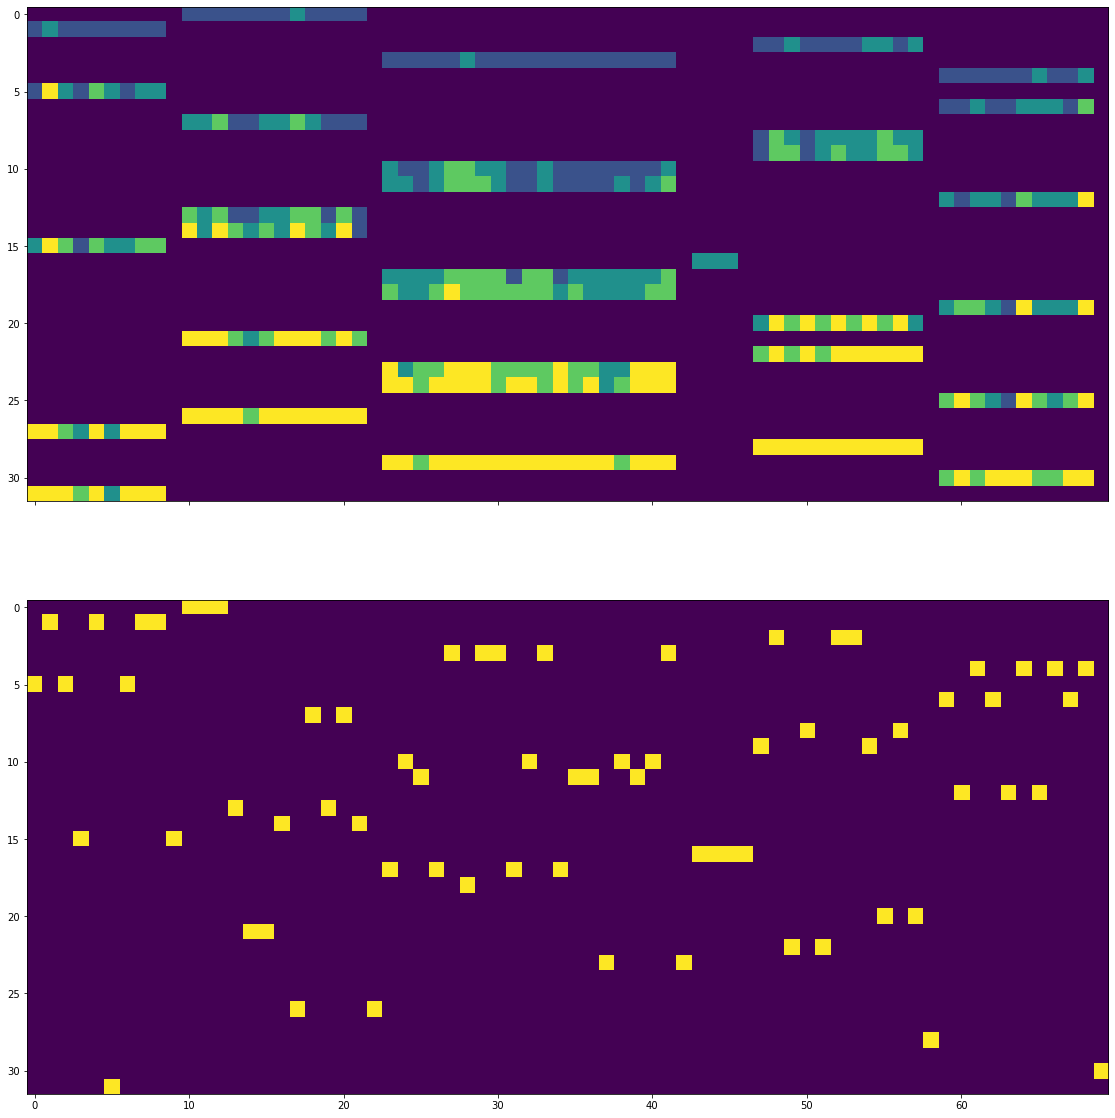

In [13]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(20,20))
ax1.imshow(cib[:,:32].T,interpolation='nearest')
ax2.imshow(assignments[:,:32].T,interpolation='nearest')
plt.savefig("Random block costs weekly schedule",dpi=500)

In [14]:
os = [[] for _ in range(n_blocks)]
gs = [[] for _ in range(n_blocks)]

for b in range(n_blocks):
    for n in range(n_scenarios):
        os[b].append(avg_model.o[b+1,n+1].value)
        gs[b].append(avg_model.g[b+1,n+1].value)

os = np.array(os)
gs = np.array(gs)

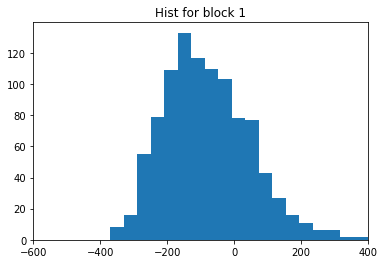

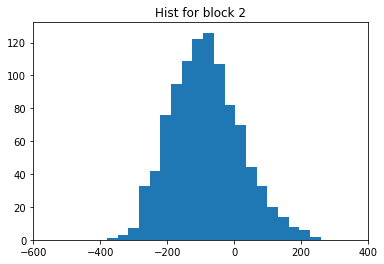

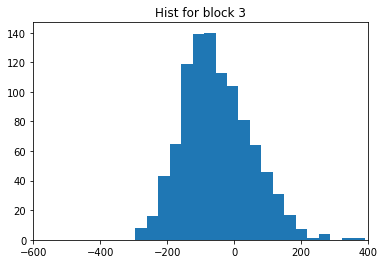

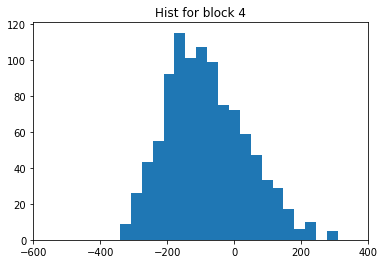

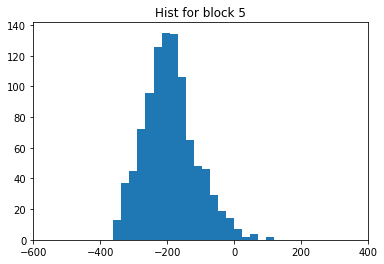

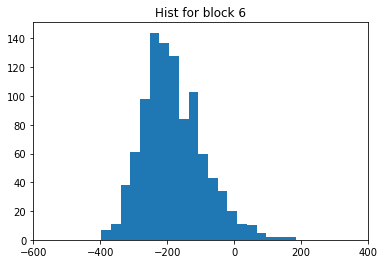

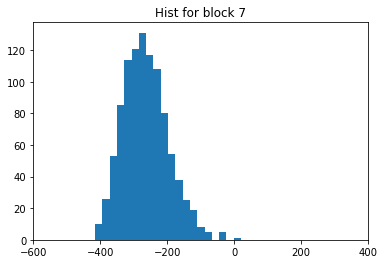

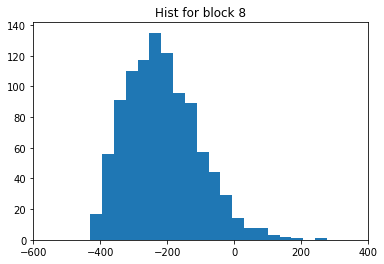

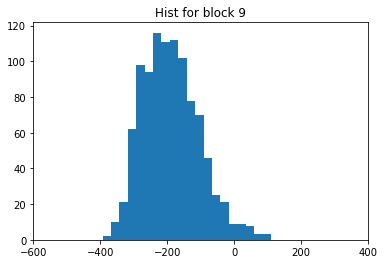

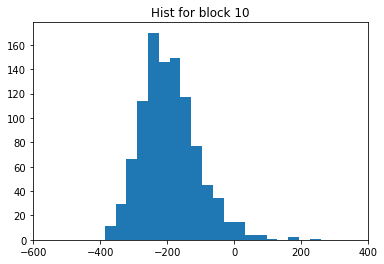

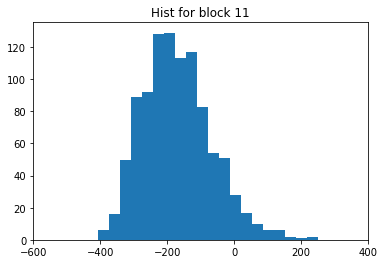

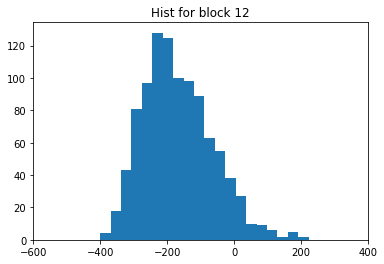

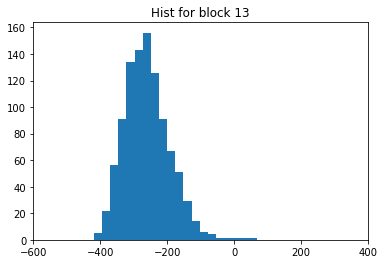

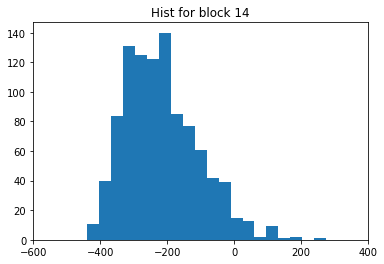

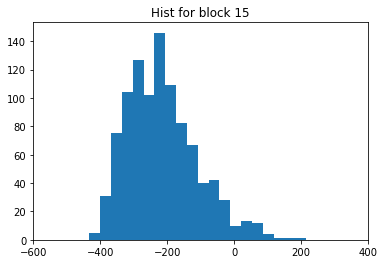

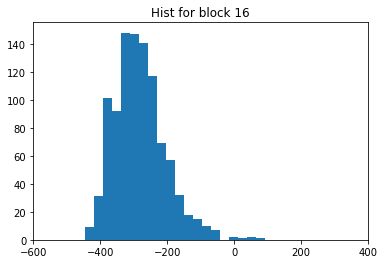

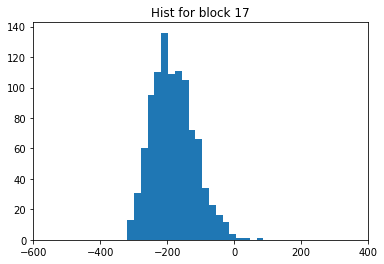

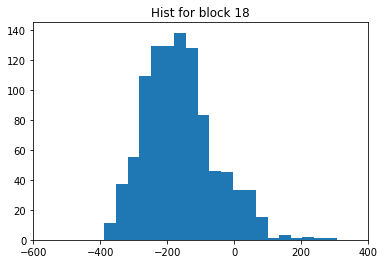

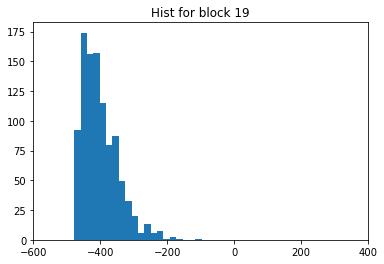

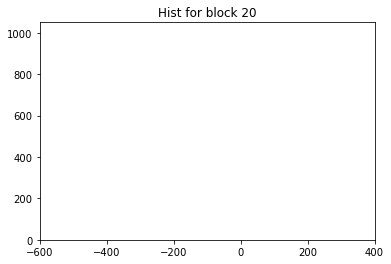

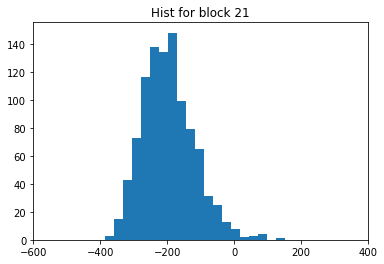

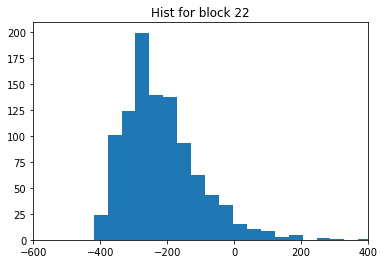

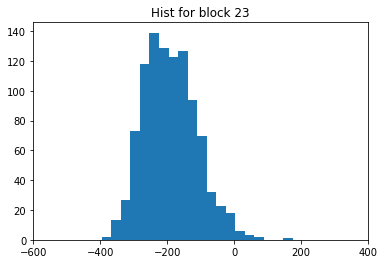

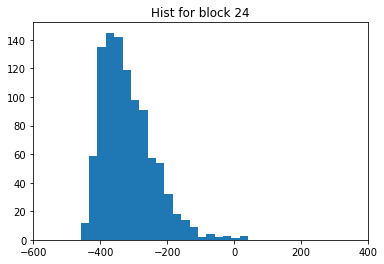

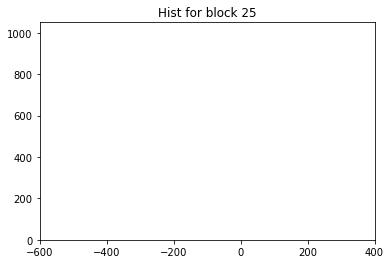

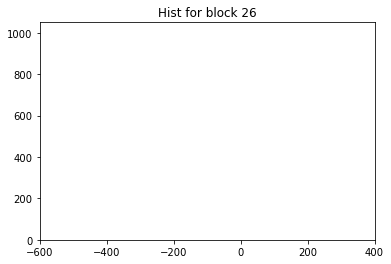

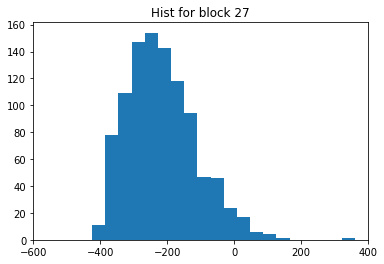

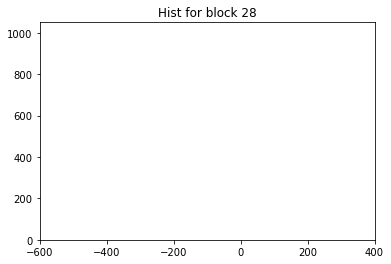

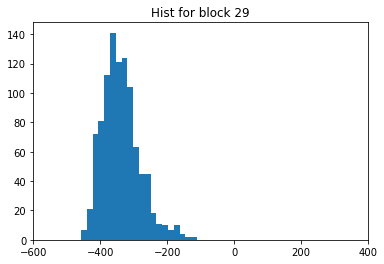

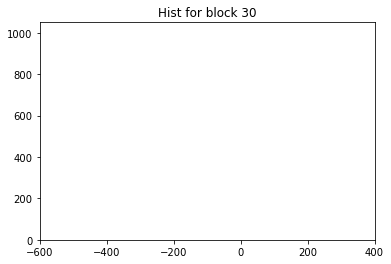

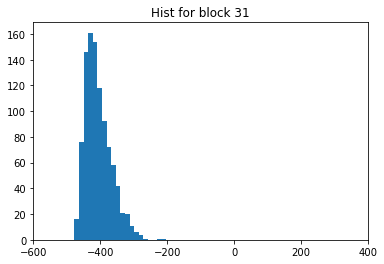

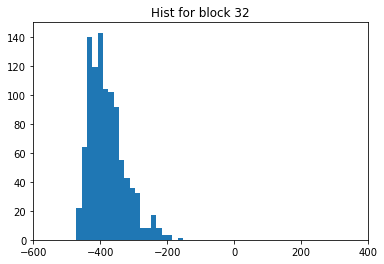

In [15]:
overtime = os-gs

for b in range(n_blocks-len(specs)):
    plt.figure()
    plt.title("Hist for block "+str(b+1))
    plt.hist(overtime[b],bins=20)
    plt.xlim(-600,400)
    plt.show()

In [16]:
cib

array([[  0., 100.,   0., ...,   0.,   0.,   0.],
       [  0., 200.,   0., ...,   0.,   0.,   0.],
       [  0., 100.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0., 800.],
       [  0.,   0.,   0., ...,   0.,   0., 800.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [17]:
cib.shape

(70, 38)

In [18]:
cib[:2,:32]

array([[  0., 100.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 200.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 400.,   0.,   0.,   0., 400.],
       [  0., 200.,   0.,   0.,   0., 400.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 400.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 400.,   0.,   0.,   0., 400.]])